<a href="https://colab.research.google.com/github/jman4162/introduction-to-causal-inference/blob/main/Python_Tutorial_Causal_Inference_in_Ad_Network_Applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Tutorial: Causal Inference in Ad Network Applications

Name: John Hodge

Date: 05/09/24

This tutorial explores how to apply causal inference techniques to assess the impact of ad network partnerships on various performance metrics, such as click-through rates, conversions, and overall revenue. We'll utilize propensity score matching, a method that helps us estimate the causal effects of different advertising strategies in a non-experimental setting.

# Prerequisites:

Ensure you have Python and the following libraries installed:

In [124]:
!pip install pandas numpy statsmodels scikit-learn matplotlib seaborn

# Step 1: Importing Libraries
Start by importing the necessary Python libraries:

In [125]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Data Preparation

For this tutorial, we'll simulate an advertising dataset where we have several covariates, a binary indicator of partnership engagement (treatment), and a performance metric (outcome).

In [126]:
# Setting the seed for reproducibility
np.random.seed(43)

# Generating synthetic data
n_samples = 1000
OFFSET = 0.5 # Adjust the distribution as needed
X = np.random.normal(0, 1, (n_samples, 3))  # Covariates
ad_effect = np.random.normal(1.5, 0.5, n_samples)  # Simulated effect of the ad network partnership
engaged = (np.random.binomial(1, p=1 / (1 + np.exp(-X[:, 0] - X[:, 1] + OFFSET)))).astype(float)  # Treatment
performance = 50 + engaged * ad_effect + X[:, 0] + 2 * X[:, 1] - 0.5 * X[:, 2] + np.random.normal(0, 2, n_samples)  # Outcome

# Creating DataFrame
df = pd.DataFrame(X, columns=['feature1', 'feature2', 'feature3'])
df['engaged'] = engaged
df['performance'] = performance

In [127]:
df.head()

,feature1,feature2,feature3,engaged,performance
0,0.257400,-0.908481,-0.378503,1.0,46.423029
1,-0.534916,0.858073,-0.413010,0.0,53.278593
2,0.498189,2.010199,1.262862,1.0,53.205656
3,-0.439215,-0.346438,0.455320,1.0,53.085178
4,-1.668663,-0.862085,0.492911,0.0,46.376980


In [128]:
# Compute descriptive statistics for each column of df
df.describe()

,feature1,feature2,feature3,engaged,performance
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.046879,0.033665,-0.013016,0.414000,50.839867
std,0.987397,1.011383,0.993520,0.492795,3.259784
min,-2.878093,-3.141032,-3.174735,0.000000,41.283694
25%,-0.596198,-0.655333,-0.745456,0.000000,48.650109
50%,0.042682,0.054291,-0.017923,0.000000,50.823192
75%,0.693287,0.718984,0.680990,1.000000,53.100028
max,3.098634,3.028167,2.896842,1.000000,59.503968


<Axes: xlabel='engaged', ylabel='performance'>

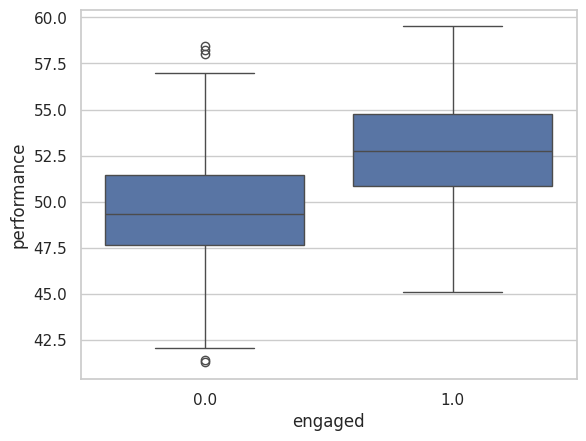

In [129]:
# Performance by Engagement
sns.boxplot(x="engaged", y="performance", data=df)

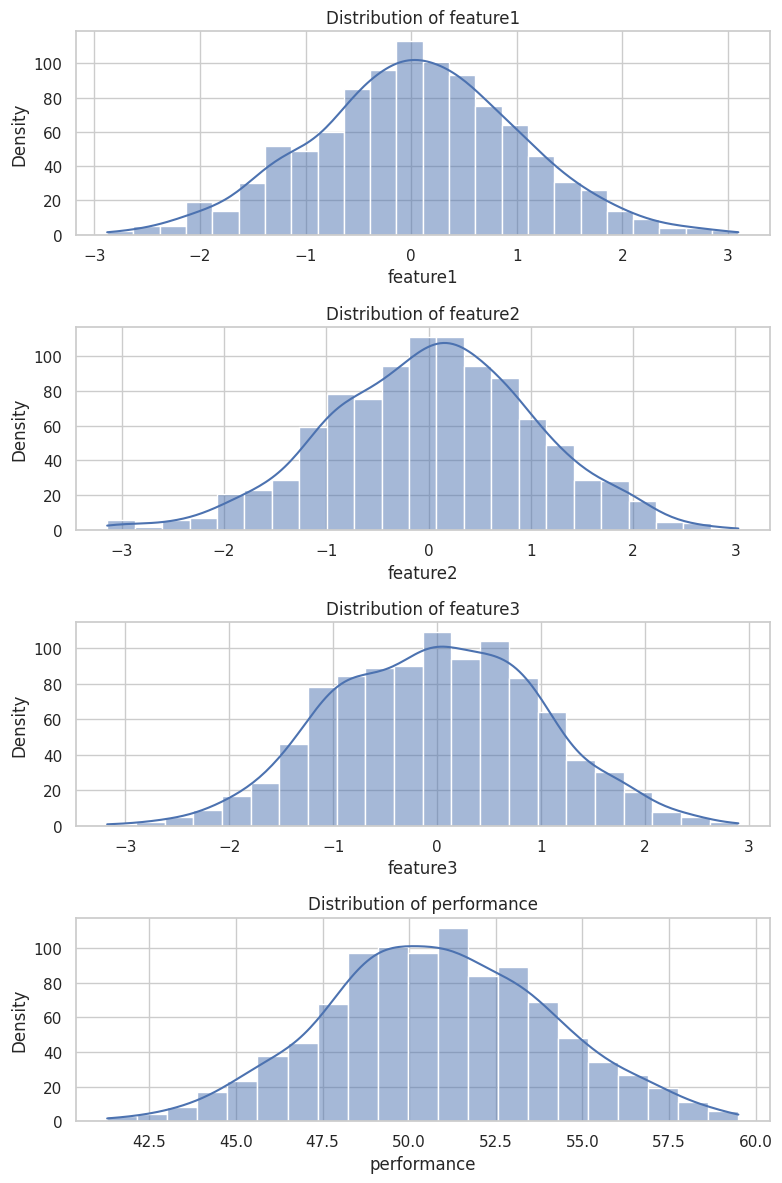

In [130]:
# Plot the distributions of each feature in df

# Set the style of seaborn for better visuals
sns.set(style="whitegrid")

# Create a figure with multiple subplots, adjusting the size as necessary
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 12))

# Names of the columns in df that correspond to features
feature_columns = ['feature1', 'feature2', 'feature3', 'performance']

# Loop through each feature and create a plot
for i, col in enumerate(feature_columns):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Step 3: Propensity Score Estimation

We'll use logistic regression to estimate the propensity scores, indicating the probability of engaging with the ad network based on observed covariates.

In [131]:
logistic = LogisticRegression()
df['propensity_score'] = logistic.fit(df[['feature1', 'feature2', 'feature3']], df['engaged']).predict_proba(df[['feature1', 'feature2', 'feature3']])[:, 1]

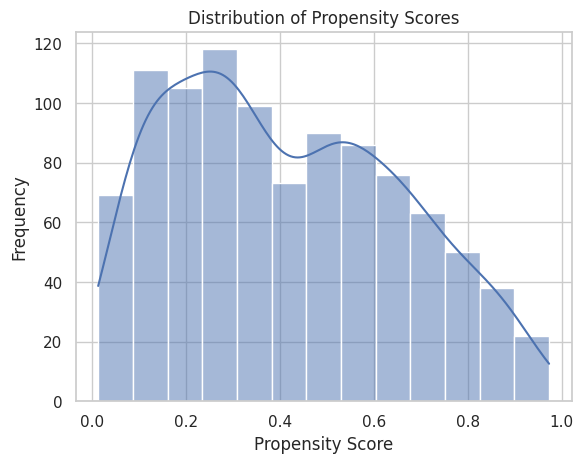

In [132]:
sns.histplot(df['propensity_score'], kde=True)
plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.show()

### Understanding Propensity Score in Causal Inference

In the context of causal inference, a **propensity score** is a probability score that quantifies the likelihood of a unit (e.g., an individual, business, etc.) receiving a particular treatment given their observed characteristics or covariates. This score is central to balancing the treatment and control groups in observational studies where random assignment of treatment is not feasible.

#### Purpose of Propensity Scores:
- **Reduce Bias:** Propensity scores help in reducing bias due to confounding variables by equating groups based on these observed covariates.
- **Mimic Randomization:** By matching or weighting subjects based on propensity scores, researchers can mimic some aspects of a randomized controlled trial, making the treatment and control groups more comparable.

#### Role in Causal Analysis:
- When treatments are not randomly assigned, there can be many differences between those who receive the treatment and those who do not, beyond the treatment itself. These differences can confound the relationship between the treatment and the outcome. Propensity scores aim to control for these differences, isolating the effect of the treatment.

### Explanation of the Propensity Score Estimation Code

The provided code snippet uses logistic regression to compute the propensity scores for each unit in the dataset. Here's a breakdown of each part of the code:

```python
logistic = LogisticRegression()
df['propensity_score'] = logistic.fit(df[['feature1', 'feature2', 'feature3']], df['engaged']).predict_proba(df[['feature1', 'feature2', 'feature3']])[:, 1]
```

1. **Initializing the Model**:
   ```python
   logistic = LogisticRegression()
   ```
   This line creates an instance of the `LogisticRegression` class from the `sklearn.linear_model` module. Logistic regression is chosen here because the treatment variable (`engaged`) is binary, making it a classification problem.

2. **Fitting the Model**:
   ```python
   logistic.fit(df[['feature1', 'feature2', 'feature3']], df['engaged'])
   ```
   - `df[['feature1', 'feature2', 'feature3']]`: This specifies the predictor variables (or features) used to estimate the probability of receiving the treatment. These features should capture the factors that influence the decision to engage.
   - `df['engaged']`: This is the response variable indicating whether the unit was engaged (1) or not (0).
   - The `fit` method adjusts the weights of the logistic regression model so that it can best predict the engagement status from the covariates.

3. **Predicting Propensity Scores**:
   ```python
   predict_proba(df[['feature1', 'feature2', 'feature3']])[:, 1]
   ```
   - After fitting the model, `predict_proba` is used to obtain the predicted probabilities for each class. Here, it returns a two-column array where the first column contains the probabilities of the negative class (not engaged), and the second column contains the probabilities of the positive class (engaged).
   - `[:, 1]`: This part of the code selects the second column, which corresponds to the probability of being engaged. These are the propensity scores.
   - The propensity scores are then stored in the DataFrame `df` under a new column named `'propensity_score'`.

#### Importance of the Propensity Score Calculation
By calculating these scores and adding them to the DataFrame, you now have a quantitative measure of the likelihood of engagement based on observable characteristics. This measure is crucial for the next steps in the causal analysis, particularly for matching, stratification, or weighting, helping to ensure that the treatment effect estimation is as unbiased as possible given the observational data.

# Step 4: Matching

Using nearest neighbor matching to pair engaged and non-engaged units based on their propensity scores.

In [133]:
from sklearn.neighbors import NearestNeighbors

# Splitting the data into engaged and non-engaged groups
engaged_group = df[df['engaged'] == 1]
non_engaged_group = df[df['engaged'] == 0]

# Using NearestNeighbors to find matches
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(non_engaged_group[['propensity_score']])
distances, indices = nn.kneighbors(engaged_group[['propensity_score']])

# Creating a matched DataFrame
matched_indices = non_engaged_group.iloc[indices.flatten()]
matched_data = pd.concat([engaged_group.reset_index(drop=True), matched_indices.reset_index(drop=True)], axis=0)

In [134]:
matched_data.head()

,feature1,feature2,feature3,engaged,performance,propensity_score
0,0.257400,-0.908481,-0.378503,1.0,46.423029,0.231523
1,0.498189,2.010199,1.262862,1.0,53.205656,0.872925
2,-0.439215,-0.346438,0.455320,1.0,53.085178,0.228332
3,-0.124313,1.935136,-0.618443,1.0,56.771333,0.759674
4,-0.160830,2.230360,-0.399116,1.0,53.974304,0.804904


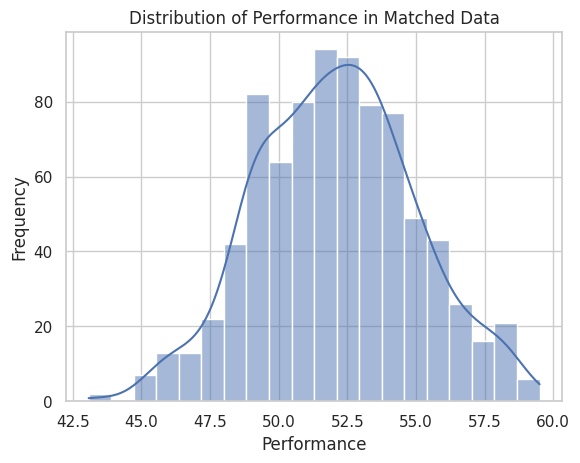

In [135]:
# Plot the distribution of matched_data['performance']
sns.histplot(matched_data['performance'], kde=True)
plt.title('Distribution of Performance in Matched Data')
plt.xlabel('Performance')
plt.ylabel('Frequency')
plt.show()

### Importance of Matching

In causal inference, particularly when dealing with observational data, matching is a crucial step that aims to reduce selection bias by making the treatment and control groups more comparable. This is vital because in non-experimental settings, the assignment to treatment or control might be influenced by confounding variables. Matching attempts to control for these confounders, allowing for a more accurate estimation of the causal effect of the treatment.

**Key Goals of Matching:**
- **Balance the covariates** between the treatment and control groups, thus reducing confounding bias.
- **Mimic randomization** as closely as possible, helping to strengthen the causal interpretation of the observed relationships.

### Why Use Nearest Neighbor Matching?

Nearest Neighbor matching is employed in this context because it is a straightforward and effective method for finding the best control match for each treated unit based on similarity in propensity scores. The idea is to find the closest match in terms of propensity score for each treated unit, thereby creating a "pseudo-randomized" setup where treated and control units are similar in observed covariates.

### Choice of 'ball_tree' Algorithm

The 'ball_tree' algorithm is chosen for several reasons:
- **Efficiency with large datasets**: 'ball_tree' is effective for datasets with a large number of samples or high dimensionality (many covariates), as it organizes the data in a tree structure that enables faster queries.
- **Handling non-uniform sample distributions**: It can efficiently handle data with varying densities, which is common in real-world datasets.
- **Speed**: It provides a good balance between preprocessing time and query time, especially important when dealing with large datasets and needing many distance computations.

### Step-by-Step Explanation of the Code

1. **Importing Required Module**:
   ```python
   from sklearn.neighbors import NearestNeighbors
   ```
   This imports the `NearestNeighbors` class, which is used to find the nearest points in a dataset — useful for implementing nearest neighbor matching.

2. **Splitting Data into Groups**:
   ```python
   engaged_group = df[df['engaged'] == 1]
   non_engaged_group = df[df['engaged'] == 0]
   ```
   - `engaged_group` contains all data points where the unit received the treatment (`engaged` == 1).
   - `non_engaged_group` includes all data points where the unit did not receive the treatment (`engaged` == 0).

3. **Setting Up Nearest Neighbors to Find Matches**:
   ```python
   nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(non_engaged_group[['propensity_score']])
   ```
   - A `NearestNeighbors` instance is created with `n_neighbors=1`, which means the algorithm will find the single closest neighbor for each point.
   - `algorithm='ball_tree'` specifies the algorithm used to compute the nearest neighbors.
   - `.fit(non_engaged_group[['propensity_score']])` prepares the model, indexing the propensity scores of the non-engaged group to be searched.

4. **Finding the Nearest Neighbors**:
   ```python
   distances, indices = nn.kneighbors(engaged_group[['propensity_score']])
   ```
   - `kneighbors()` finds the nearest neighbor for each propensity score in the `engaged_group`. It returns:
     - `distances`: The distances of the nearest neighbors.
     - `indices`: The indices of these neighbors in the `non_engaged_group`.

5. **Creating a Matched DataFrame**:
   ```python
   matched_indices = non_engaged_group.iloc[indices.flatten()]
   matched_data = pd.concat([engaged_group.reset_index(drop=True), matched_indices.reset_index(drop=True)], axis=0)
   ```
   - `indices.flatten()` converts the indices array to a 1D array suitable for indexing.
   - `non_engaged_group.iloc[indices.flatten()]` retrieves the rows from `non_engaged_group` corresponding to these indices, which are the matched controls for each treated unit.
   - `pd.concat()` combines the treated group and their matched controls into a single DataFrame, creating a balanced dataset for further analysis.

### Conclusion

The matching step, particularly using nearest neighbor matching with a sophisticated algorithm like 'ball_tree', is instrumental in reducing biases due to confounding variables and enhancing the reliability of causal effect estimates in observational studies. This process is a cornerstone of robust causal inference in real-world scenarios where randomized controlled trials are not feasible.

# Step 5: Analyzing the Effect

Finally, we analyze the average effect of ad network engagement on performance metrics.

In [136]:
# Calculate and display the Average Treatment Effect on the Engaged (ATE)
weights = np.where(matched_data['engaged'] == 1, 1, -1)
weighted_scores = weights * matched_data['performance']
stats = DescrStatsW(weighted_scores)
print(f"Estimated Average Treatment Effect: {stats.mean:.3f}")

Estimated Average Treatment Effect: 0.741


Here’s a breakdown of the code and the interpretation of the result:

### Code Breakdown

1. **Weight Assignment**:
   ```python
   weights = np.where(matched_data['engaged'] == 1, 1, -1)
   ```
   This line creates an array of weights for calculating the ATE. For each entry in the `matched_data` DataFrame:
   - If the `engaged` column is `1` (indicating that the unit was engaged with the treatment), the weight is `1`.
   - If the `engaged` column is `0` (indicating the unit was not engaged, hence part of the control group), the weight is `-1`.

   The purpose of these weights is to compute the effect of engagement by contrasting engaged units directly against non-engaged units.

2. **Weighted Performance Calculation**:
   ```python
   weighted_scores = weights * matched_data['performance']
   ```
   This line multiplies each weight by the corresponding performance score. Engaged units (weight = 1) keep their performance scores positive, while the performance scores of non-engaged units (weight = -1) are negated. This operation effectively sets up the dataset for calculating the difference in performance attributable to the treatment by summing these weighted scores.

3. **Statistical Calculation**:
   ```python
   stats = DescrStatsW(weighted_scores)
   ```
   `DescrStatsW` from the `statsmodels` library computes weighted descriptive statistics for the `weighted_scores`. In this context, it prepares to calculate a weighted mean, which will reflect the average treatment effect.

### Meaning of the Result

**Estimated Average Treatment Effect: 0.741**:
- The result indicates that engaging with the treatment (in this context, likely some form of advertising or marketing campaign within an ad network) leads to an average increase in the performance metric (such as click-through rate, conversion rate, sales volume, etc.) of 0.741 units compared to not engaging.
- A positive ATE of 0.741 suggests that the treatment is effective in enhancing the performance metric under study.

### Implications

This positive ATE value is valuable for decision-makers as it quantifies the beneficial impact of engagement. If the performance metric represents a critical business outcome (e.g., revenue or customer acquisition), the result supports continuing or expanding the engagement strategy. However, further analysis would be necessary to validate these findings across different contexts or explore deeper into the causality, ensuring that other confounding factors are accounted for.

### Discussion

In the context of causal inference, the Average Treatment Effect (ATE) is a crucial measure that quantifies the average impact of a treatment (or intervention) across all units in the study. This measure is particularly important in scenarios where the treatment is not randomly assigned, which is often the case in observational studies, such as those conducted in ad network applications.

#### Connection Between ATE and Causal Inference

1. **Defining Causality**:
   - Causal inference seeks to determine whether, and to what extent, a cause (the treatment) affects an outcome. This differs from correlation, which merely indicates that two variables are related without specifying a directional or causal relationship.

2. **Importance of ATE**:
   - The ATE provides a numerical estimate of the effect size of the treatment, which in the given code snippet is the engagement with an ad network feature or campaign. It tells us how much the outcome variable (performance) is expected to change, on average, due to the treatment.
   - Specifically, a positive ATE (0.741 in this case) suggests that on average, engaging with the ad network leads to an improvement in performance metrics by 0.741 units compared to not engaging.

#### Methodological Considerations

3. **Propensity Score Matching and Causality**:
   - In the background of calculating ATE, propensity score matching is often employed (as suggested by the creation of `matched_data`). This method attempts to mimic a randomized controlled trial by matching each treated unit with one or more control units that have similar characteristics (except for the treatment).
   - This matching helps to balance out confounding variables—factors that could influence the outcome independently of the treatment. By controlling for these confounders, we aim to isolate the effect of the treatment itself on the outcome.

4. **Weighted Analysis**:
   - The use of weights (`1` for treated and `-1` for control units) in calculating the ATE enhances the ability to directly compare the effects of treatment versus non-treatment within the matched dataset. Weighting treated and control units inversely allows their effects to be summed into a single estimate, emphasizing the direct impact of the treatment.
   - This approach effectively adjusts the contribution of each group to the overall metric, emphasizing the difference (or contrast) between them, which is central to determining causality.

#### Interpretation and Practical Implications

5. **Implications of the Positive ATE**:
   - A positive ATE implies that the treatment (engagement) causally increases the performance metric. This is useful for decision-makers within the organization, suggesting that increasing engagement activities could lead to better business outcomes.
   - However, while the ATE offers valuable insights, it does not provide the complete picture. It averages the treatment effect across all units, which might obscure important variations in how different subgroups respond to the treatment.

6. **Further Analytical Steps**:
   - Despite the valuable insights provided by the ATE, further investigation into the robustness of these findings is essential. This can include sensitivity analyses to test how dependent the results are on certain assumptions or conditions.
   - Additionally, examining other causal inference metrics like the Average Treatment Effect on the Treated (ATT) or the Conditional Average Treatment Effect (CATE) can provide deeper insights, especially into how specific segments of the population are affected differently by the treatment.

In summary, the ATE is a foundational element in causal inference that quantifies the average expected impact of a treatment, helping to guide strategic decisions based on an understanding of causal relationships rather than mere associations. This understanding is crucial for effectively leveraging ad network engagements to enhance business performance.

# Conclusion

This tutorial introduced you to causal inference techniques applied to ad network partnerships. By carefully matching engaged and non-engaged units based on propensity scores, we can estimate the causal impact of ad network strategies on performance metrics, providing valuable insights for optimizing advertising efforts and strategic planning in digital marketing environments. This approach helps ensure that decisions are data-driven and grounded in a robust analysis of causal effects.